In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.8 MB/s eta 0:00:00


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy.ndimage as ndi
import os
import pandas as pd
import cv2
import random

from sklearn.model_selection import train_test_split
import shutil
from PIL import Image

#imports for pyroch lighting
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import Callback

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from tqdm.notebook import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
import torch.nn.functional as F
import torch

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


KeyboardInterrupt: 

In [ ]:
class TextureDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)]

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image

In [ ]:
class ResizeIfSmaller:
    def __init__(self, size=256):
        self.size = size

    def __call__(self, img):
        w, h = img.size
        if w < self.size or h < self.size:
            #Bilinear to keep aspect ratio
            img = transforms.Resize(self.size, interpolation=Image.BILINEAR)(img)
        return img

In [ ]:
#transformations: randomcrop to enforce size
train_transform = transforms.Compose([
    ResizeIfSmaller(256),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(), #Totensor can already normalize to [0,1]
])
valTest_transform = transforms.Compose([
    ResizeIfSmaller(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = TextureDataset(root_dir='/content/drive/MyDrive/!mlData/sandtexturedataset/train', transform=train_transform)
val_dataset = TextureDataset(root_dir='/content/drive/MyDrive/!mlData/sandtexturedataset/val', transform=valTest_transform)
test_dataset = TextureDataset(root_dir='/content/drive/MyDrive/!mlData/sandtexturedataset/test', transform=valTest_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

Implementation of CNN-based Variatonal Autoencoder Model with Pytorch Lighting

In [ ]:
#encoder implementation
#can use 4th conv layer in encoder and 1st transpose_conv layer in decoder for higher compression. Currently not used in forward functions

class Encoder(nn.Module):
    def __init__(self, latent_dim=128):  # Adjust latent_dim as needed
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)  # 256 -> 128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # 128 -> 64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # 64 -> 32
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # 32 -> 16

        self.fc_mu = nn.Linear(256 * 16 * 16, latent_dim)  # Latent mean
        self.fc_log_var = nn.Linear(256 * 16 * 16, latent_dim)  # Latent log-variance

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # Flatten for linear layer
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

#VAE Decoder Implementation
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 16 * 16) #flattened, so need to match the size

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)  # 16 -> 32
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)  # 32 -> 64
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # 64 -> 128
        self.deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)  # 128 -> 256

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 256, 16, 16) #reshape back to prev conv layer's output shape
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.deconv4(x)) #Need to normalzie pixel values to [0,1] values
        return x

In [ ]:
#https://medium.com/@alejandro.itoaramendia/decoding-the-u-net-a-complete-guide-810b1c6d56d8#8e28
class EncoderUnet(nn.Module):
    def __init__(self, latent_dim=128):
        super(Encoder, self).__init__()
        #only use stried of 2 at last conv layer in block, to downsample
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 256 -> 256
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # 256 -> 128
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 128 -> 128
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),  # 128 -> 64
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 64 -> 64
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),  # 64 -> 32
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # 32 -> 32
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # Latent space projection (fully connected layers for mean and log variance)
        self.fc_mu = nn.Linear(512 * 16 * 16, latent_dim)
        self.fc_log_var = nn.Linear(512 * 16 * 16, latent_dim)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(x.size(0), -1)  # Flatten for linear layers
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

In [ ]:
#reparam step for VAEs:
def reparameterize(mu, log_var):
    std = torch.exp(0.5 * log_var)
    epsilon = torch.randn_like(std)
    return mu + std * epsilon

In [ ]:
#VAE Class
class VAE(L.LightningModule):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.test_loss_list = []

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = reparameterize(mu, log_var)
        reconstructed_img = self.decoder(z)
        return reconstructed_img, mu, log_var #after one encoder-decoder pass, recon_img used to calculate recon_loss. (mu, log_var) for kl_divergence

    def _get_vae_loss(self, batch):
        x = batch
        x_hat, mu, log_var = self(x) #get from forward pass

        #recon loss
        recon_loss = F.mse_loss(x_hat, x, reduction='sum')

        #KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        return recon_loss + 0.01*kl_loss

    def training_step(self, batch, batch_idx):
        loss = self._get_vae_loss(batch) #minimize on combined recon, kl loss
        self.log("train_loss", loss, logger=True, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_vae_loss(batch)
        self.log("val_loss", loss, logger=True, prog_bar=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self._get_vae_loss(batch)
        self.test_loss_list.append(loss.item())
        self.log("test_loss", loss, logger=True, prog_bar=True, on_epoch=True)
        return loss

    def on_test_epoch_end(self): #return the losses of test samples. Accssed via class-object.test_loss_list
        return {"test_loss_list": self.test_loss_list}

    def configure_optimizers(self):
        #add l2 reg term to reduce overfitting (weight_decay)
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        #lr scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=5, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}


In [ ]:
#VAE Initializations
latent_dim = 256 #latent dimension for the latent space of VAE. Larger might be better for larger images

encoder = Encoder(latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim)

vae = VAE(encoder, decoder)

In [ ]:
trainer=Trainer(accelerator='auto',max_epochs=100)

In [ ]:
trainer.fit(vae, train_loader, val_loader)

In [ ]:
trainer.test(vae, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       7018.55078125       │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 7018.55078125}]

In [ ]:
results = trainer.predict(vae, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

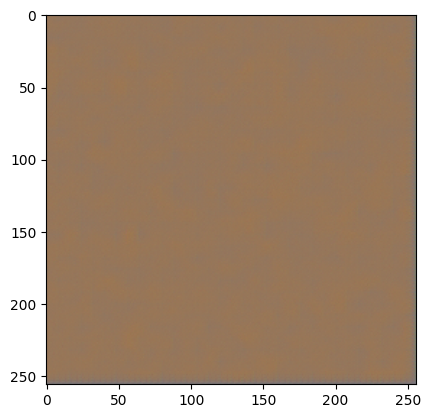

In [ ]:
im = results[2][0].squeeze(0)
torch.
im = im.permute(1,2,0)
plt.imshow(im)

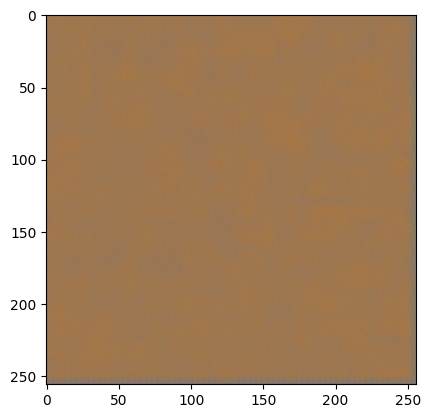

In [ ]:
im = results[0][0].squeeze(0)
im = im.permute(1,2,0)
plt.imshow(im)

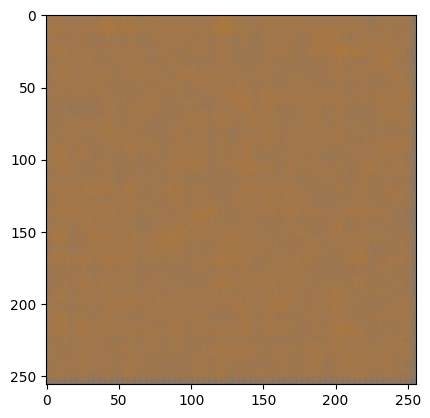

In [ ]:
im = results[1][0].squeeze(0)
im = im.permute(1,2,0)
plt.imshow(im)